# Double-bracket Iteration other cost functions and respective scheduling

This notebook presents two additional cost functions for the double-bracket flow: least-squares and energy fluctuation with their respectice scheduling methods.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCostFunction
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *

### Least-squares

The cost function is defined as: $\frac{1}{2}||D-H_k||^2 =\frac{1}{2}(||D||^2+||H||^2) -Tr(D H_k)$ as in (the negative of https://epubs.siam.org/doi/abs/10.1137/S0036141092229732?journalCode=sjmael) We seek to minimize this function at each DBF iteration. For numerical optimizations, we also ignore the norm of H term as for a given hamiltonian it is fixed through out the flow.


In [ ]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)



In [ ]:
# generate data for plotting sigma decrease of the first step
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/2**nqubits
s_space = np.linspace(1e-5, 1.0, 500)
off_diagonal_norm_diff = []
potential = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
    potential.append(dbi_eval.least_squares(d=d))

# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
# polynomial
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
print('polynomial_approximation step:', step_poly)

In [ ]:
# Plot the results
plt.figure()
plt.plot(s_space, potential)
plt.xlabel('s')
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.title('First DBI step')
plt.ylabel('Least squares cost function')
plt.legend()
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

Comparison of the least-squares cost function with the original cost function using the polynomial scheduling method

In [ ]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
off_diagonal_norm_diff = [dbi.off_diagonal_norm]
off_diagonal_norm_diff_least_squares = [dbi.off_diagonal_norm]
iters = 100
dbi_ls = deepcopy(dbi)
cost = DoubleBracketCostFunction.off_diagonal_norm
dbi_od = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
for _ in range(iters):
    step_poly = dbi_od.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_od(step_poly,d=d)
    step_poly = dbi_ls.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_ls(step_poly,d=d)
    off_diagonal_norm_diff.append(dbi_od.off_diagonal_norm)
    off_diagonal_norm_diff_least_squares.append(dbi_ls.off_diagonal_norm)

In [ ]:
plt.figure()
plt.plot(range(iters+1), off_diagonal_norm_diff, label=r'Off-diagonal norm')
plt.plot(range(iters+1), off_diagonal_norm_diff_least_squares, label=r'Least squares')
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()


### Energy fluctuation

This cost function is defined as: $\Xi_k^2 (\mu) = \langle \mu | H_k^2| \mu \rangle - \langle \mu | H_k| \mu \rangle^2$. We must specify the state $| \mu \rangle$ for which we want to minimize the fluctuation. The overall diagonalization isn't guaranteed.


In [ ]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 3
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the energy fluctuation cost function
cost = DoubleBracketCostFunction.off_diagonal_norm
# define the state
state = np.zeros(2**nqubits)
state[3] = 1
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost, ref_state=state)

In [ ]:
# generate data for plotting sigma decrease of the first step
d = np.diag(np.linspace(2**nqubits,1,2**nqubits))/2**nqubits
s_space = np.linspace(-1, 1, 1000)
off_diagonal_norm_diff = []
fluctuation = []
for s in s_space:
    dbi_eval = deepcopy(dbi)
    dbi_eval(s,d=d)
    off_diagonal_norm_diff.append(dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
    fluctuation.append(dbi_eval.energy_fluctuation(state=state))

# grid_search
step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
print('grid_search step:', step_grid)
# hyperopt
step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
print('hyperopt_search step:', step_hyperopt)
# polynomial
step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
print('polynomial_approximation step:', step_poly)


In [ ]:
# Plot the results
plt.figure()
plt.plot(s_space, fluctuation)
plt.xlabel('s')
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label ='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.title('First DBI step')
plt.ylabel('Energy fluctuation')
plt.legend()
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff)
plt.axvline(x=step_grid, color='r', linestyle='-',label='grid_search')
plt.axvline(x=step_hyperopt, color='g', linestyle='--',label='hyperopt')
plt.axvline(x=step_poly, color='m', linestyle='-.',label='polynomial')
plt.ylabel(r'$||\sigma(H_0)||-\sigma(H_k)||$')
plt.xlabel('s')
plt.title('First DBI step')
plt.legend()
print('The minimum for cost function in the tested range is:', step_grid)

In [ ]:
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
off_diagonal_norm_diff = [dbi.off_diagonal_norm]
energy_fluc = [dbi.energy_fluctuation(state=state)]
iters = 10
dbi_ = deepcopy(dbi)
for _ in range(iters):
    step_poly = dbi_.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
    dbi_(step_poly,d=d)
    off_diagonal_norm_diff.append(dbi_.off_diagonal_norm)
    energy_fluc.append(dbi_.energy_fluctuation(state=state))

In [ ]:
plt.figure()
plt.plot(range(iters+1), off_diagonal_norm_diff)
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')

plt.figure()
plt.plot(range(iters+1), energy_fluc)
plt.xlabel('Iterations')
plt.ylabel(r'Energy fluctuation')


In [ ]:
iters = 30
states = [0,1,2,3,4,5,6,7]
energy = np.empty((len(states),iters))


d = (np.diag(np.linspace(1,2**nqubits,2**nqubits)))
for i in range(len(states)):
    dbi_ = deepcopy(dbi)
    dbi_.state = states[i]
    for j in range(iters):
        step_poly = dbi_.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d, n=3)
        if step_poly is not None:
            dbi_(step_poly, d=d)
        energy[i,j] = np.real(dbi_.h.matrix[states[i],states[i]])
    

In [ ]:
eigvals = np.linalg.eigh(dbi_.h.matrix)[0]
print('Eigenvalues:', eigvals )
plt.figure()
for i in range(len(states)):
    plt.plot(range(iters), energy[i,:],'.', label='State ' + str(states[i]))
for eigvals in eigvals:
    plt.axhline(y=eigvals, color='r', linestyle='--')
plt.xlabel('Iterations')


### Gradients for finding optimal $D$

An advantage of the least-squares cost function is that one can use gradient descent and the learning is more stable than with the off-diagonal cost function.

In [2]:
from qibo.models.dbi.utils_gradients import *

In [3]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the energy fluctuation cost function
cost = DoubleBracketCostFunction.energy_fluctuation
# define the state
state = np.zeros(2**nqubits)
state[3] = 1
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost, ref_state=state)

[Qibo 0.2.7|INFO|2024-05-23 10:27:34]: Using numpy backend on /CPU:0


Text(0, 0.5, 'Diagonal elements')

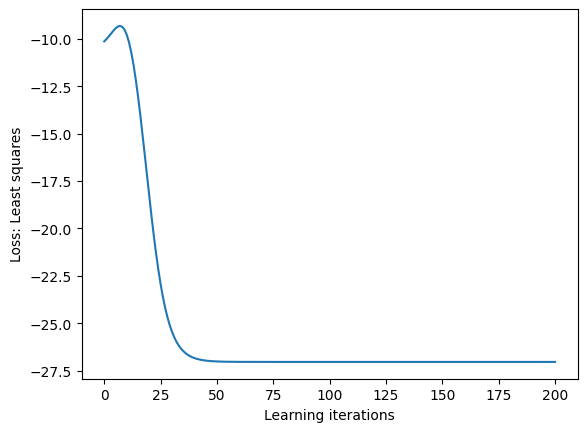

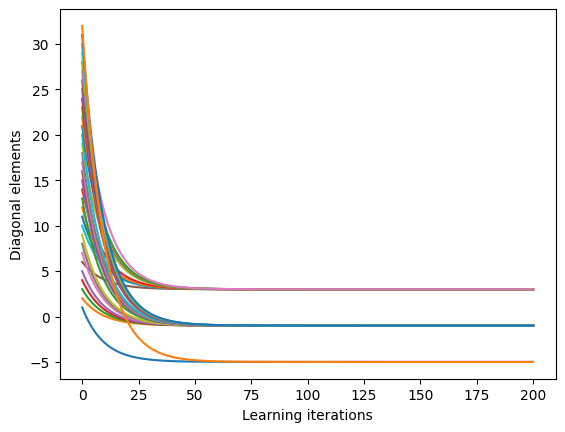

In [6]:
cost = DoubleBracketCostFunction.least_squares
nqubits = 5
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
params = np.linspace(1,2**nqubits,2**nqubits)

step = 1e-1
iterations = 200
d, loss, grad, diags = gradient_descent_dbr_d_ansatz(dbi, params, iterations, step)

plt.figure()
plt.plot(range(iterations+1), loss)
plt.xlabel('Learning iterations')
plt.ylabel('Loss: Least squares')

plt.figure()
for i in range(2**nqubits):
    plt.plot(diags[i,:], label='State ' + str(i))
plt.xlabel('Learning iterations')
plt.ylabel('Diagonal elements')


Training for $D$ can greatly improve the decrease of the off-diagonal norm at each iteration. Nonetheless, during training the ascending values condition may be no longer satisfied creating a exponential decrease after few iterations

Text(0, 0.5, '$||\\sigma(H_k)||$')

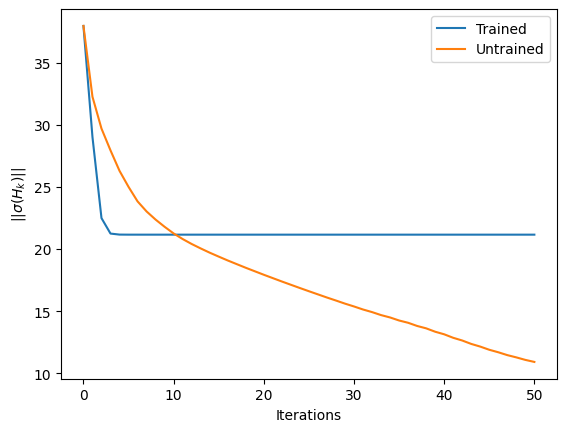

In [7]:
cost = DoubleBracketCostFunction.least_squares
nqubits = 5
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=3.0)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
params = np.linspace(1,2**nqubits,2**nqubits)
d_fixed = np.diag(params)
dbi_trained = deepcopy(dbi)
flows = 50
iterations = 200
off_diagonal_norm = np.empty((2,flows+1))
off_diagonal_norm[0,0] = dbi_trained.off_diagonal_norm
off_diagonal_norm[1,0] = dbi.off_diagonal_norm
d_trained, loss, grad, diags = gradient_descent_dbr_d_ansatz(dbi_trained, params, iterations,step)
for i in range(flows):

    s = dbi_trained.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d_trained, n=3)
    dbi_trained(s,d=d_trained)
    off_diagonal_norm[0,i+1] = dbi_trained.off_diagonal_norm
    s = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d_fixed, n=3)
    dbi(s,d=d_fixed)
    off_diagonal_norm[1,i+1] = dbi.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm[0,:], label='Trained')
plt.plot(off_diagonal_norm[1,:], label='Untrained')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')



A solution can be to redo the training at each step, with a $D$ having ascending values

Text(0, 0.5, '$||\\sigma(H_k)||$')

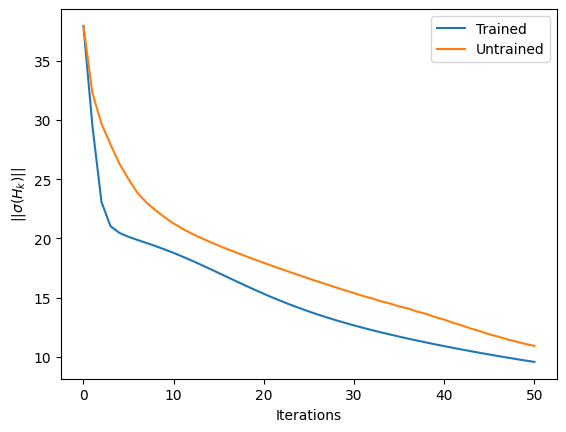

In [9]:
cost = DoubleBracketCostFunction.least_squares
nqubits = 5
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=3.0)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
params = np.linspace(1,2**nqubits,2**nqubits)
d_fixed = np.diag(params)
dbi_trained = deepcopy(dbi)
flows = 50
iterations = 20
off_diagonal_norm = np.empty((2,flows+1))
off_diagonal_norm[0,0] = dbi_trained.off_diagonal_norm
off_diagonal_norm[1,0] = dbi.off_diagonal_norm

for i in range(flows):
    d_trained, loss, grad, diags = gradient_descent_dbr_d_ansatz(dbi_trained, params, iterations,step)
    s = dbi_trained.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d_trained, n=3)
    dbi_trained(s,d=d_trained)
    off_diagonal_norm[0,i+1] = dbi_trained.off_diagonal_norm
    s = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation, d=d_fixed, n=3)
    dbi(s,d=d_fixed)
    off_diagonal_norm[1,i+1] = dbi.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm[0,:], label='Trained')
plt.plot(off_diagonal_norm[1,:], label='Untrained')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')

## 1-local ansatz

We can consider, as an alternative to the a fully parametrized diagonal, a diagonal matrix of the form: $D = \sum \alpha_i Z_i$. This has the advantage of having a linear number of parameters to optimize instead of an exponential as well as being easier to implement in a quantum computer 

In [10]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares

# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-05-23 10:29:12]: Using numpy backend on /CPU:0


In [11]:
dbi_eval = deepcopy(dbi)
params = np.linspace(1,2**nqubits,2**nqubits)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent_dbr_d_ansatz(dbi, params,  100,lr=1e-2, d_type = d_ansatz_type.element_wise)
flows = 50
off_diagonal_norm = np.empty((flows+1,2))
off_diagonal_norm[0,:] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm



dbi_eval = deepcopy(dbi)
params = np.linspace(1,nqubits,nqubits)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent_dbr_d_ansatz(dbi, params,  30, lr=1e-3, d_type = d_ansatz_type.local_1)
best = np.argmin(loss_opt)
d_opt = d_ansatz(diags_opt[:,best], d_ansatz_type.local_1)
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,1] = dbi_eval.off_diagonal_norm


[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:29:15]: Calculating the dens

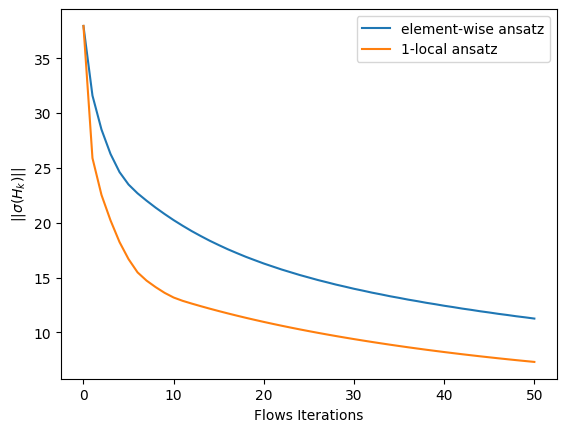

In [12]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label='element-wise ansatz')
plt.plot(off_diagonal_norm[:,1],label='1-local ansatz')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

In [25]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares

# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-05-23 10:35:55]: Using numpy backend on /CPU:0


In [52]:
dbi_eval = deepcopy(dbi)
params = np.linspace(1,2**nqubits,2**nqubits)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent_dbr_d_ansatz(dbi, params,  100,lr=1e-2, d_type = d_ansatz_type.element_wise)
flows = 30
off_diagonal_norm = np.empty((flows+1,3))
off_diagonal_norm[0,:] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm

dbi_eval = deepcopy(dbi)
params = np.linspace(1,nqubits,nqubits)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent_dbr_d_ansatz(dbi, params,  30, lr=1e-1, d_type = d_ansatz_type.local_1)

for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,1] = dbi_eval.off_diagonal_norm

dbi_eval = deepcopy(dbi)
params = np.linspace(1,nqubits,nqubits)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent_dbr_d_ansatz(dbi, params,  30, lr=1e-1, d_type = d_ansatz_type.local_1,normalize=True)

for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=5)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,2] = dbi_eval.off_diagonal_norm



[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-23 10:41:53]: Calculating the dens

0.9999999999999999


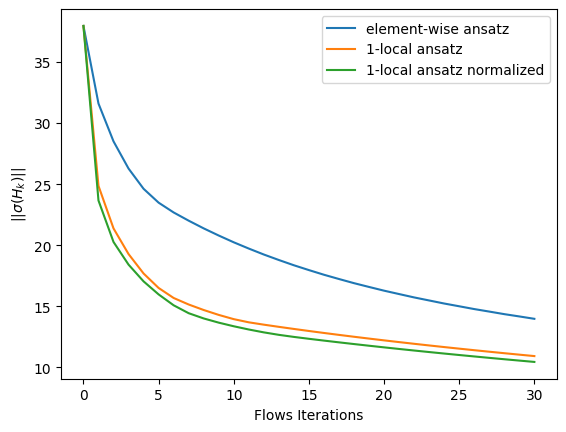

In [53]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label='element-wise ansatz')
plt.plot(off_diagonal_norm[:,1],label='1-local ansatz')
plt.plot(off_diagonal_norm[:,2],label='1-local ansatz normalized')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

print(np.linalg.norm(d_opt))